# Self-Driving Car Engineer Nanodegree

## Project: Behavioral Cloning

**Desciption:** This project aims to create a CNN model which is trained using simulation data to predict steering angles based on camera images on a simulation vehicle.

![](img/sample.gif)

---
## Step 0: Importing Librarires

In [1]:
import os
import csv
import random
import numpy as np
import cv2

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

from PIL import Image
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers.core import Dense, Activation, Flatten, Dropout

from keras.layers import Cropping2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

Using TensorFlow backend.
/Users/ugururesin/opt/miniconda3/envs/TFtraining/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/ugururesin/opt/miniconda3/envs/TFtraining/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/ugururesin/opt/miniconda3/envs/TFtraining/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qi

---
## Step 1: Loading The Raw Data

In [4]:
lines = []
header = True
camera_images = []
steering_angles = []

with open('data/driving_log.csv', 'r') as f:
    reader = csv.reader(f, delimiter=';')
    for row in reader:
        if header:
            header = False
            continue
        steering_center = float(row[3])

        #Steering angle (sa) correction factor for stereo cameras
        sa_cor = 0.2
        steering_left = steering_center + sa_cor
        steering_right = steering_center - sa_cor

        #Reading camera images from their paths
        path_src1 = row[0]
        path_src2 = row[1]
        path_src3 = row[2]
        img_name1 = path_src1.split('/')[-1]
        img_name2 = path_src2.split('/')[-1]
        img_name3 = path_src3.split('/')[-1]
        path1 = 'data/IMG/' + img_name1 
        path2 = 'data/IMG/' + img_name2 
        path3 = 'data/IMG/' + img_name3 

        #Image and Steering Dataset
        img_center = np.asarray(Image.open(path1))
        img_left = np.asarray(Image.open(path2))
        img_right = np.asarray(Image.open(path3))
        camera_images.extend([img_center, img_left, img_right])
        steering_angles.extend([steering_center, steering_left, steering_right])

---

## Step 2: Dataset Summary & Visual Exploration

In [8]:
print('Number of images: ' + str(len(camera_images)))

Number of images: 7464


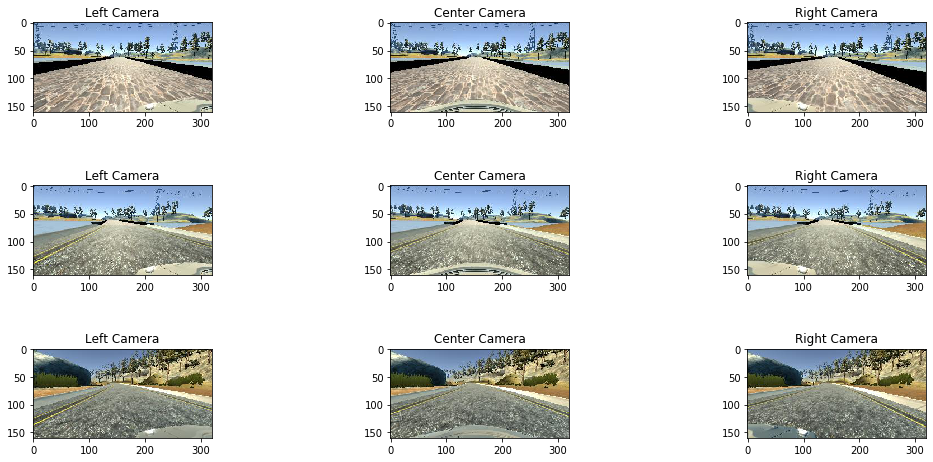

In [3]:
# Visualizing some random images with their labels
fig, ax = plt.subplots(3,3, figsize=(16,8))
fig.subplots_adjust(hspace = .5, wspace=1)
ax = ax.ravel()
for i in range(0,8,3):
    #Creating a random idx number that will correspond to a left-cam image
    idx = random.randint(10, len(camera_images))
    idx = idx - (idx % 3) + 1 
    
    #Creating left, center, right images
    img_l = camera_images[idx]
    img_c = camera_images[idx - 1]
    img_r = camera_images[idx + 1 ]
    
    #Plotting images
    ax[i].imshow(img_l)
    ax[i].set_title('Left Camera')
    
    ax[i+1].imshow(img_c)
    ax[i+1].set_title('Center Camera')
    
    ax[i+2].imshow(img_r)
    ax[i+2].set_title('Right Camera')

----

## Step 3: Data Augmentation

Here, the camera images and the corresponding steering angles are augmented in order to increase the number of images!

In [5]:
augmented_imgs, augmented_sas= [],[]

for aug_img,aug_sa in zip(camera_images,steering_angles):
    augmented_imgs.append(aug_img)
    augmented_sas.append(aug_sa)
    
    #Flipping the image
    augmented_imgs.append(cv2.flip(aug_img,1))
    
    #Reversing the steering angle for the flipped image
    augmented_sas.append(aug_sa*-1.0) 

X_train, y_train = np.array(augmented_imgs), np.array(augmented_sas)
X_train, y_train = np.array(camera_images), np.array(steering_angles)

----

## Step 4: Pre-Processing the Images

Here, a function is defined to pre-process the camera images  

In [6]:
def preprocess(image):
    import tensorflow as tf
    #Resizing the image
    return tf.image.resize_images(image, (200, 66))

----

## Step 5: Creating the CNN Architecture

Here, a CNN architecture is defined by using Keras Sequential() method.

The CNN architecture is used from NVIDIA's End to End Learning for Self-Driving Cars paper.  
**Reference:** https://arxiv.org/pdf/1604.07316v1.pdf

![](img/cnn.png)

In [6]:
#Keras Sequential Model
model = Sequential()

#Image cropping to get rid of the irrelevant parts of the image (the hood and the sky)
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))

#Pre-Processing the image
model.add(Lambda(preprocess))
model.add(Lambda(lambda x: (x/ 127.0 - 1.0)))

#The layers
model.add(Conv2D(filters=24, kernel_size=(5, 5), strides=(2, 2),activation='relu'))
model.add(Conv2D(filters=36, kernel_size=(5, 5),strides=(2, 2), activation='relu'))
model.add(Conv2D(filters=48, kernel_size=(5, 5), strides=(2, 2),activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3) ,activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3),activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1))
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 200, 66, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 200, 66, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 31, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 14, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 5, 48)         43248     
________________________________________________

----

## Step 6: Compiling and Saving the Model

Initially, the number of **epochs** is set to 10!  

However, the validation loss is started to increase after the 6th epoch progressively (as shown below).  
Thus, the number of **epochs** is set to 6!  
  
![](img/epochs10.png)

In [7]:
model.compile(loss='mse',optimizer='adam') #adaptive moment estimation
model.fit(X_train,y_train,validation_split=0.2,shuffle=True,nb_epoch=6)
model.save('model.h5') 
print('The model.h5 file has been created!') 

Instructions for updating:
Use tf.cast instead.


/Users/ugururesin/opt/miniconda3/envs/TFtraining/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 5971 samples, validate on 1493 samples
Epoch 1/6
5971/5971 [==============================] - 42s 7ms/step - loss: 0.0164 - val_loss: 0.0630
Epoch 2/6
5971/5971 [==============================] - 46s 8ms/step - loss: 0.0081 - val_loss: 0.0552
Epoch 3/6
5971/5971 [==============================] - 42s 7ms/step - loss: 0.0051 - val_loss: 0.0628
Epoch 4/6
5971/5971 [==============================] - 40s 7ms/step - loss: 0.0035 - val_loss: 0.0632
Epoch 5/6
5971/5971 [==============================] - 40s 7ms/step - loss: 0.0026 - val_loss: 0.0595
Epoch 6/6
5971/5971 [==============================] - 37s 6ms/step - loss: 0.0020 - val_loss: 0.0685
The model.h5 file has been created!
